In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib
from collections import deque, namedtuple
from tqdm.notebook import tqdm
from typing import List
import numpy as np
import itertools
import random
import math
import time

In [2]:
from IPython import display

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [4]:
N = 8
k = 3

# Environment
This class describes the $N$-Queen environment and provides helper methods relating to it. The board is represented in `row major` representation.

In [78]:
class NQueenEnv:
    def __init__(self, n:int, k:int):
        self.n = n
        self.k = k
        self._reset() # Initializes empty board
        
    def _reset(self):
        """
            Sets the board to a matrix of zeros, from this a random k-queen partial n-queen solution can be set
        """
        self.board = np.zeros(self.n*self.n)
        self.rows, self.cols, self.diags, self.anti_diags = set(), set(), set(), set()
        
    def reset(self) -> np.array:
        """
            Resets board with new partial N-Queens configuration
        """        
        has_set = False
        while not has_set:
            self._reset() # resets board and line sets
            num_set = 0
            while num_set < self.k:
                if not self.get_avail_squares(): break
                action = self.sample_action()
                self._perform_action(action)
                
                num_set += 1
                
            has_set = num_set == self.k
    
        return self.board # 1D array -> partial config
    
    def _perform_action(self, action:int):
        """
        Performs action i.e. places queen on square (action//n, action (mod n))
        """
        row,col = action//self.n, action%self.n
        self.rows.add(row)
        self.cols.add(col)
        self.diags.add(col-row)
        self.anti_diags.add(col+row)
        
        self.board[action] = 1
        
    def get_avail_squares(self) -> List[int]:
        """
        Finds all available squares in (x,y) format
        """
        avail = []
        for i,j in itertools.product(range(self.n), range(self.n)):
            if i in self.rows or j in self.cols or j-i in self.diags or j+i in self.anti_diags: continue
            avail.append((i,j))
        return avail
    
    def sample_action(self) -> int:
        """
        Returns a random action to take i.e. a random available square
        """
        row, col = random.sample(self.get_avail_squares(), 1)[0]
        return self.n * row + col
    
    @staticmethod
    def step(state, action:int) -> tuple:
        """
            Performs action on the board, assumes that the action is valid
        """
        avail = self.get_avail_squares()
        self._perform_action(action)
        terminate = len(self.rows) == self.n or len(avail) == 0
        reward = len(avail)/self.n
        return (self.board.copy(), reward, terminate) # new_state, reward, teminated
    
    @staticmethod
    def get_valid_mask(state):
        rows,cols,diags,anti_diags = set(), set(), set(), set()
        for i, j in itertools.product(range(N), range(N)):
            if state[N*i + j] == 0: continue
            rows.add(i)
            cols.add(j)
            diags.add(j-i)
            anti_diags.add(j+i)
        
        mask = [0] * N**2
        for i,j in itertools.product(range(N), range(N)):
            if i in rows or j in cols or j-i in diags or j+i in anti_diags: continue
            mask[i*N + j] = 1
        
        return np.asarray(mask)
    
    @staticmethod
    def get_sample_action(state):
        mask = NQueenEnv.get_valid_mask(state)
        valid_actions = [i for i in range(N*N) if mask[i]]
        return random.sample(valid_actions, 1)[0]
    
    def display(self, fontsize:int=10):
        matrix = np.zeros((self.n, self.n), dtype=int)
        for i in range(self.n**2):
            matrix[i//self.n][i%self.n] = int(self.board[i])
        
        n = matrix.shape[0]
        # Create a chess board (n x n) pattern
        board = np.zeros_like(matrix)
        board[1::2, ::2] = 1
        board[::2, 1::2] = 1

        cmap = ListedColormap(['#769656', '#eeeed2'])
        fig, ax = plt.subplots()
        ax.imshow(board, cmap=cmap, interpolation='nearest')

        # Place queens based on matrix
        for i in range(n):
            for j in range(n):
                if matrix[i, j] == 1:
                    ax.text(j, i, '♛', fontsize=fontsize, ha='center', va='center', color='black' if board[i, j] else 'white')

        # Hide the axes
        ax.set_xticks([])
        ax.set_yticks([])

In [79]:
env = NQueenEnv(N, k)
env

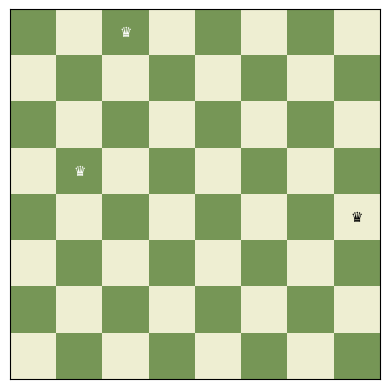

14 (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1.75, False)


In [80]:
env.reset()
env.display()
plt.show()
action = env.sample_action()
print(action, env.step(action))

# Model
Note that both a `policy net` and a `target net` neural net is created.

The `policy_net` is essentially the regular NN trying to estimate the Q-values for each action (expected reward | action), but the Q-values will be updated quite frequently leading to unstable training.

This is where the `target_net` comes in, as periodically the `policy_net` weights are copied to `target_net`. The fixed values provided by `target_net` is used to stabilize the training of the `policy_net`.

In [81]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [82]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(n_observations, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_actions)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [83]:
# Get number of actions from gym action space
n_actions = N*N
# Get the number of state observations
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
policy_net

DQN(
  (fc1): Linear(in_features=64, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
)

In [84]:
state = env.reset()
result = policy_net(torch.as_tensor(state, dtype=torch.float32))
result

tensor([-0.0636,  0.0084, -0.0258, -0.0035,  0.0085, -0.0104, -0.0011, -0.0377,
         0.0228, -0.0167,  0.0281, -0.0807, -0.0358,  0.0373, -0.0506, -0.0096,
        -0.0422, -0.0620, -0.0047, -0.0237,  0.0499, -0.0452,  0.0024, -0.0135,
        -0.0173,  0.0285, -0.0033,  0.0051, -0.0150,  0.0079,  0.0462, -0.0611,
        -0.0040, -0.0008,  0.0049, -0.0191, -0.0607, -0.0535, -0.0425, -0.0284,
        -0.0297,  0.0267, -0.0252, -0.0369, -0.0382, -0.0440, -0.0041,  0.0036,
        -0.0510, -0.0453,  0.0161,  0.0217, -0.0121, -0.0526,  0.0052, -0.0124,
         0.0441, -0.0286, -0.0037,  0.0153, -0.0641,  0.0184, -0.0136,  0.0612],
       grad_fn=<AddBackward0>)

In [85]:
result.max(0)[1].item()

63

In [86]:
result.max(0).indices.view(1,1)

tensor([[63]])

# Training
We're doing $\epsilon$-greedy method.

### Hyperparameters and utilities

In [87]:
# Hyperparameters for training

BATCH_SIZE = 128 # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99 # GAMMA is the discount factor
EPS_START = 0.9 # EPS_START is the starting value of epsilon
EPS_END = 0.05 # EPS_END is the final value of epsilon
EPS_DECAY = 1000 # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005 # TAU is the update rate of the target network
LR = 1e-4 # LR is the learning rate of the ``AdamW`` optimizer

In [93]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            infered_policy = policy_net(state)
            # Mask out invalid actions
            mask = torch.as_tensor(env.get_valid_mask(state))
            infered_policy *= mask
            return infered_policy.max(0).indices.view(1, 1)
            
    else:
        return torch.tensor([[env.get_sample_action(state)]], device=device, dtype=torch.long)

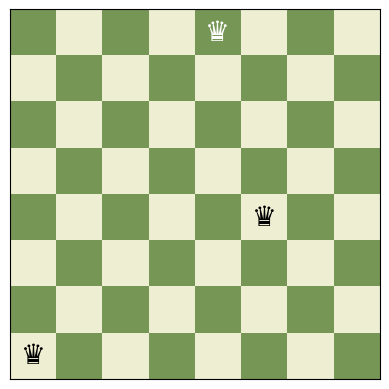

tensor([[9]])

In [94]:
state = torch.as_tensor(env.reset(), dtype=torch.float32)
env.display(fontsize=20)
plt.show()
select_action(state)

In [95]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Training loop

In [96]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

In [97]:
num_episodes = 600
    
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in itertools.count():
        action = select_action(state[0])
        print(state, action)
        observation, reward, terminated = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

  0%|          | 0/600 [00:00<?, ?it/s]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]) tensor([[39]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]) tensor([[4]])
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]) tensor([[50]])


ValueError: Sample larger than population or is negative

# Inferrence

In [23]:
def plot_state_history(state_history, n):
    fig, axs = plt.subplots(1, len(state_history), figsize=(len(state_history)*4, 4))
    if len(state_history) == 1:  # If there's only one state, axs is not an array
        axs = [axs]
        
    for ax, state in zip(axs, state_history):
        matrix = state.reshape((n, n))  # Assuming state is a flat array
        board = np.zeros_like(matrix)
        board[1::2, ::2] = 1
        board[::2, 1::2] = 1
        cmap = ListedColormap(['#769656', '#eeeed2'])
        ax.imshow(board, cmap=cmap, interpolation='nearest')
        
        for i in range(n):
            for j in range(n):
                if matrix[i, j] == 1:
                    ax.text(j, i, '♛', fontsize=10, ha='center', va='center', color='black' if board[i, j] else 'white')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    plt.show()

In [24]:
def get_next_queen(env):
    state = env.board
    state = torch.as_tensor(state, dtype=torch.float32).unsqueeze(0)
    print(state)
    with torch.no_grad():
        infered_policy = policy_net(state)
        # Mask out invalid actions
        mask = torch.as_tensor(env.get_valid_mask())
        infered_policy *= mask
        action = infered_policy.max(1).indices.view(1, 1).item()
        return action

In [29]:
state_history = []

# Random k-queen partial config
state = env.reset()
state_history.append(state.copy())

# completions
while len(env.get_avail_squares()):
    action = select_action(torch.tensor(state, dtype=torch.float32))
    
    print(action, action.item())
    print([state[N*i:N*(i+1)] for i in range(N)])
    action = action.item()
    env._perform_action(action)
    state = env.board.copy()
    state_history.append(state)


tensor([[22]]) 22
[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0.])]
tensor([[41]]) 41
[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0.])]
tensor([[2]]) 2
[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), ar

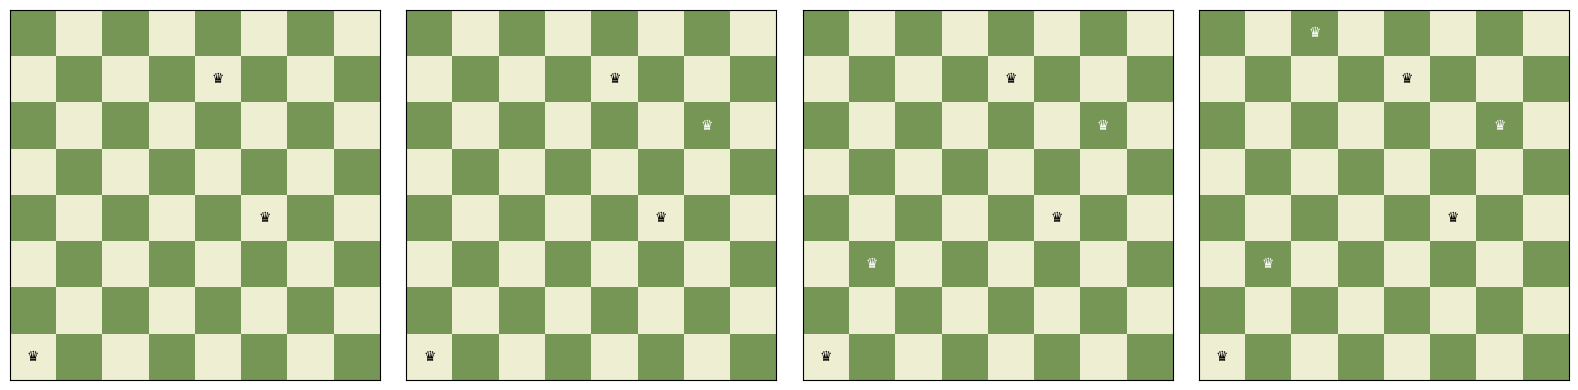

In [30]:
plot_state_history(state_history, N)